In [310]:
import astropy.units as u
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
os.environ['PYSYN_CDBS'] = '/Users/vbajaj/Documents/cdbs_local/'
import pysynphot as S

from astropy.coordinates import match_coordinates_sky, SkyCoord
from astropy.io import fits
from astropy.table import Table, hstack
from astropy.units import Quantity
from ginga.util import zscale
from matplotlib.colors import LogNorm
from multiprocessing import Pool
%matplotlib notebook

In [311]:
import matplotlib as mpl

mpl.rcParams['xtick.labelsize'] = 10
plt.rcParams.update({'axes.titlesize' : '14',
                     'axes.labelsize' : '12',
                     'xtick.labelsize' : '12',
                     'ytick.labelsize' : '12'})

In [312]:
cd ../output/  # OR WHEREVER THE CATALOGS ARE STORED

/Users/vbajaj/Documents/hipeec/output


This function loads the catalog and can deal with some of the bad values:

In [313]:
def load_cat(cat, replace_bad=True):
    tbl = pd.read_csv(cat,sep='\t')
    if replace_bad:
        tbl = tbl.replace(66.666, np.nan)
        tbl = tbl.replace(99.999, np.nan)
    return tbl

In [314]:
tbl = load_cat('final_cat_ngc1614_2017-12-15.cat')

### Basic looks at the data

Create a plot centered around the median RA/Dec of the sources, 3 sigma wide

<IPython.core.display.Javascript object>


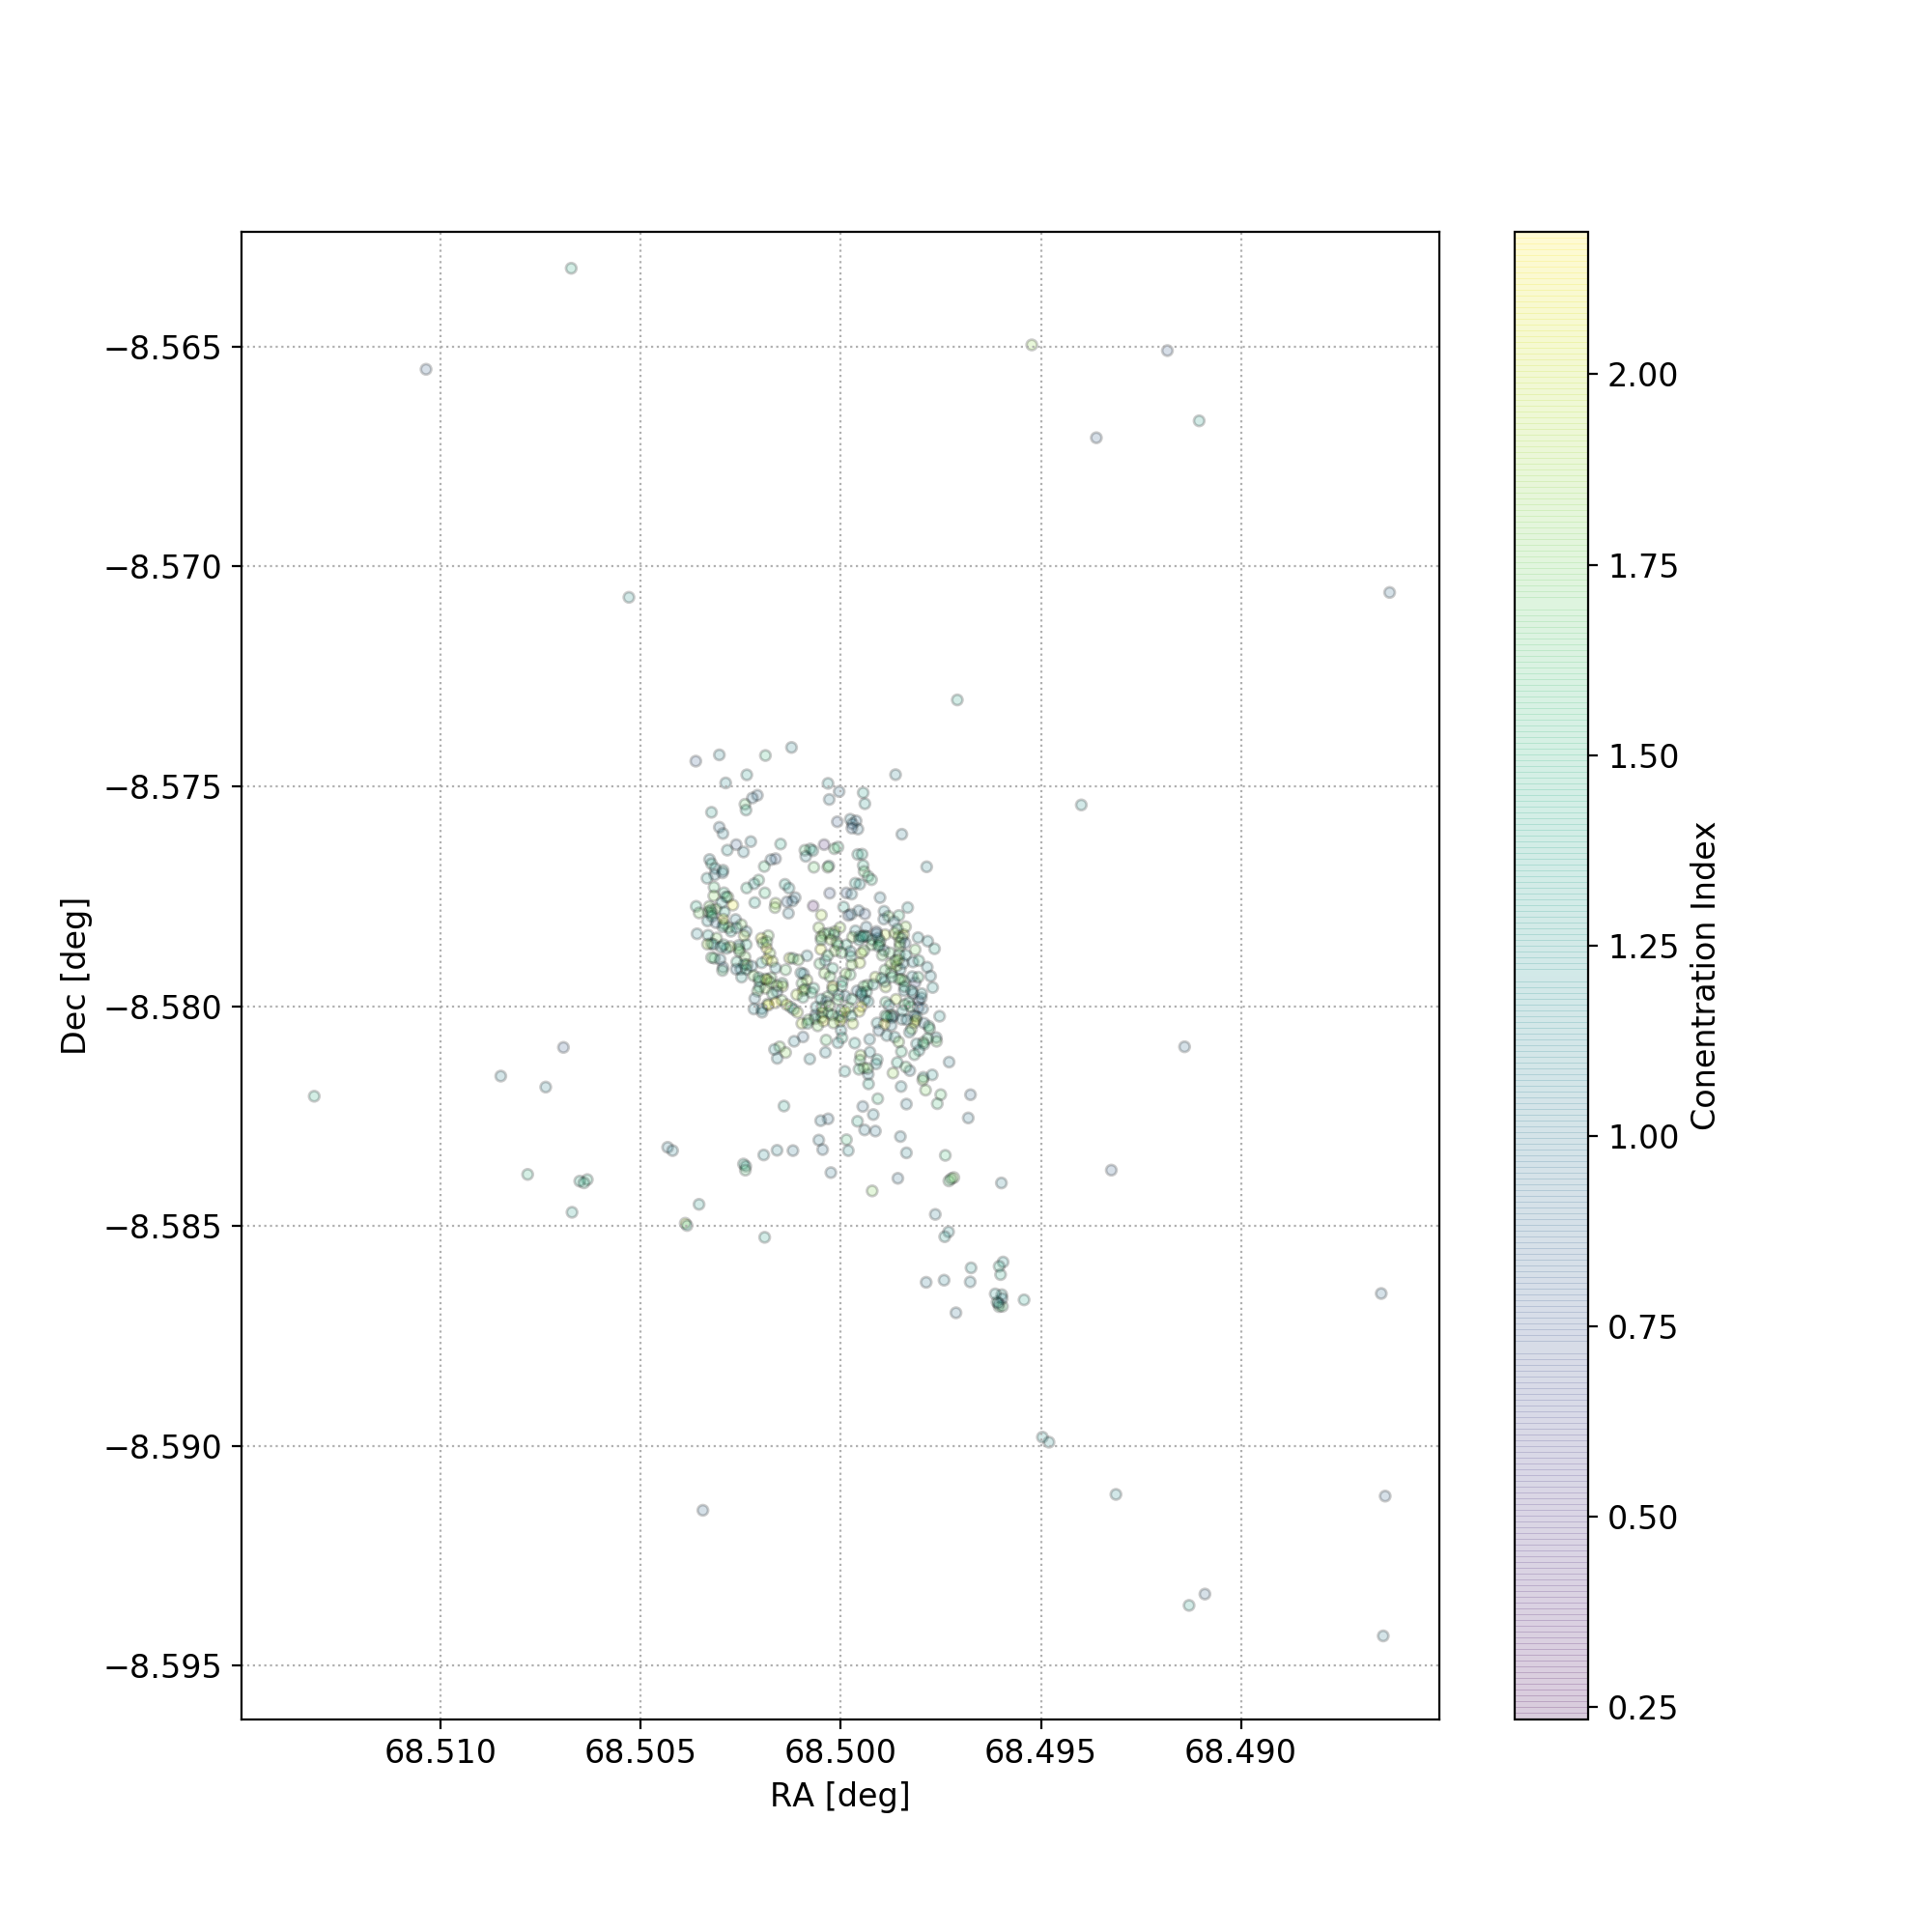

In [355]:
# Quick test of the catalog data
fig = plt.figure(figsize=[10,10])
plt.scatter(tbl['RA'], tbl['DEC'],alpha=.2,s=15,c=tbl['CI'],edgecolor='k')
cb = plt.colorbar()
plt.grid(ls=':')

med_ra = np.median(tbl['RA'])
med_dec = np.median(tbl['DEC'])
std_ra = np.std(tbl['RA'])
std_dec = np.std(tbl['DEC'])

plt.xlim(med_ra + 3 * std_ra, med_ra - 3 * std_ra)
plt.ylim(med_dec - 3 * std_dec, med_dec + 3 * std_dec)
plt.xlabel('RA [deg]')
plt.ylabel('Dec [deg]')
cb.set_label('Conentration Index')

Print the first 5 rows.

In [356]:
tbl.head()

Unnamed: 0         X         Y         RA       DEC     CI  Mag F110W  \
0           0  2018.000  5003.516  68.512602 -8.544415  0.406        NaN   
1           1  1913.000  4940.465  68.514077 -8.545291  0.386        NaN   
2           2  2249.000  4921.693  68.509358 -8.545552  0.358        NaN   
3           3  2853.444  4510.522  68.500868 -8.551262  1.377        NaN   
4           4  2804.000  4452.000  68.501563 -8.552075  0.901        NaN   

   Err F110W  Mag F130N  Err F130N    ...      Mag F336W  Err F336W  \
0        NaN        NaN        NaN    ...            NaN        NaN   
1        NaN        NaN        NaN    ...      26.469737   0.424656   
2        NaN        NaN        NaN    ...      25.797737   0.241109   
3        NaN        NaN        NaN    ...            NaN        NaN   
4        NaN        NaN        NaN    ...      22.795737   0.212201   

   Mag F435W  Err F435W  Mag F555W  Err F555W  Mag F665N  Err F665N  \
0  25.589693   0.293343  22.595944   0.043419        NaN        NaN   
1  26.927693   0.336972  23.283944   0.052804   24.49507   0.436152   
2  25.879693   0.311434  22.903944   0.043177   24.30207   0.201674   
3  25.370693   0.183167  24.867944   0.062292   24.03907   0.253727   
4  21.496693   0.153669  20.425944   0.042110   19.50407   0.073549   

   Mag F814W  Err F814W  
0  26.098492   0.176503  
1  26.616492   0.263881  
2  26.802492   0.184245  
3  24.480492   0.172572  
4  20.051492   0.167431  

[5 rows x 24 columns]

Make some histograms

<IPython.core.display.Javascript object>


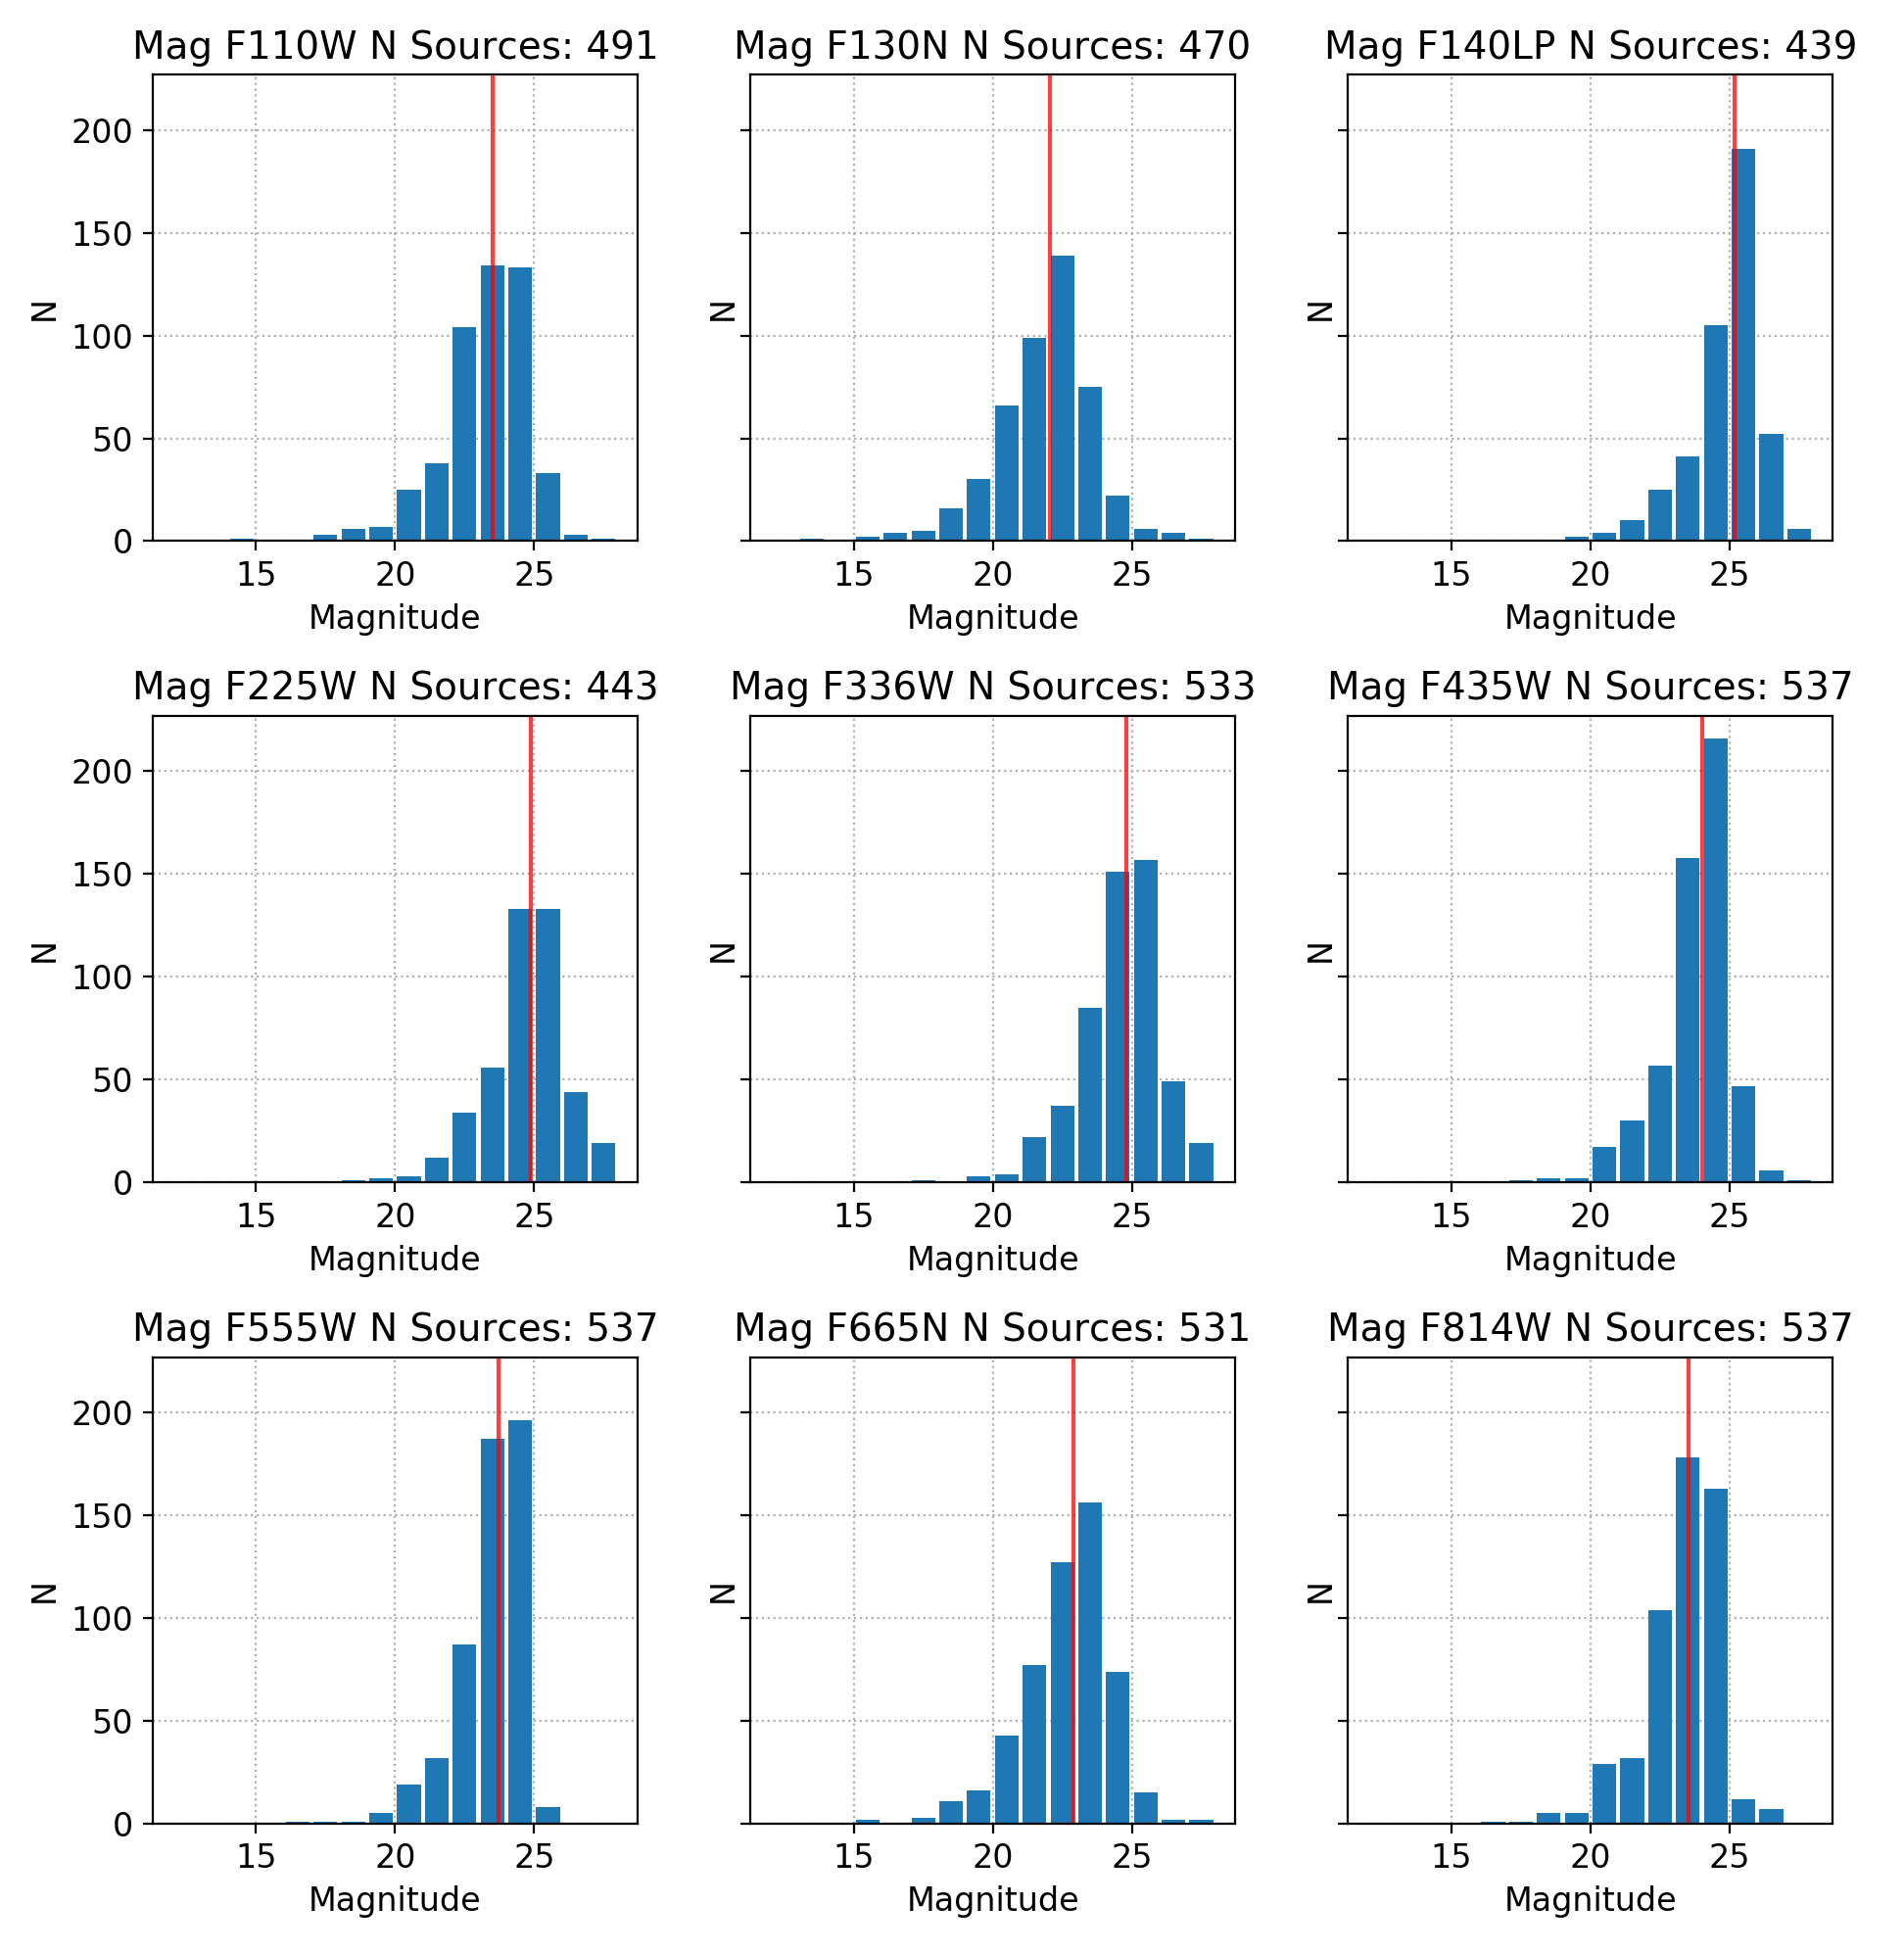

In [361]:
fig, axes = plt.subplots(3, 3, sharey=True, figsize=[10,10], squeeze=False)
i = 0
for col in tbl.columns:
    if 'Mag' not in col:
        continue
    mags = tbl[col]
    mags_filt = mags[~np.isnan(mags)]
    plot_inds = np.unravel_index(i, (3, 3))
    axes[plot_inds].grid(ls=':',zorder=0)
    h, b, p = axes[plot_inds].hist(mags_filt, rwidth=.85,zorder=2,range=[12,28],bins=16)
    med = np.median(mags_filt)
    axes[plot_inds].axvline(x=med, ls='-', alpha=.75,color='r')
    axes[plot_inds].set_title('{} N Sources: {}'.format(col, len(mags_filt)))
    axes[plot_inds].set_ylabel('N')
    axes[plot_inds].set_xlabel('Magnitude')

    i += 1
plt.tight_layout()

## Analyze the data

### Compute colors of interest

For simplicity, let's use these shorthand versions of the column names.

The shorthand names are just the names of the bands.

In [363]:
U = 'Mag F336W'
B = 'Mag F435W'
V = 'Mag F555W'
I = 'Mag F814W'

<IPython.core.display.Javascript object>


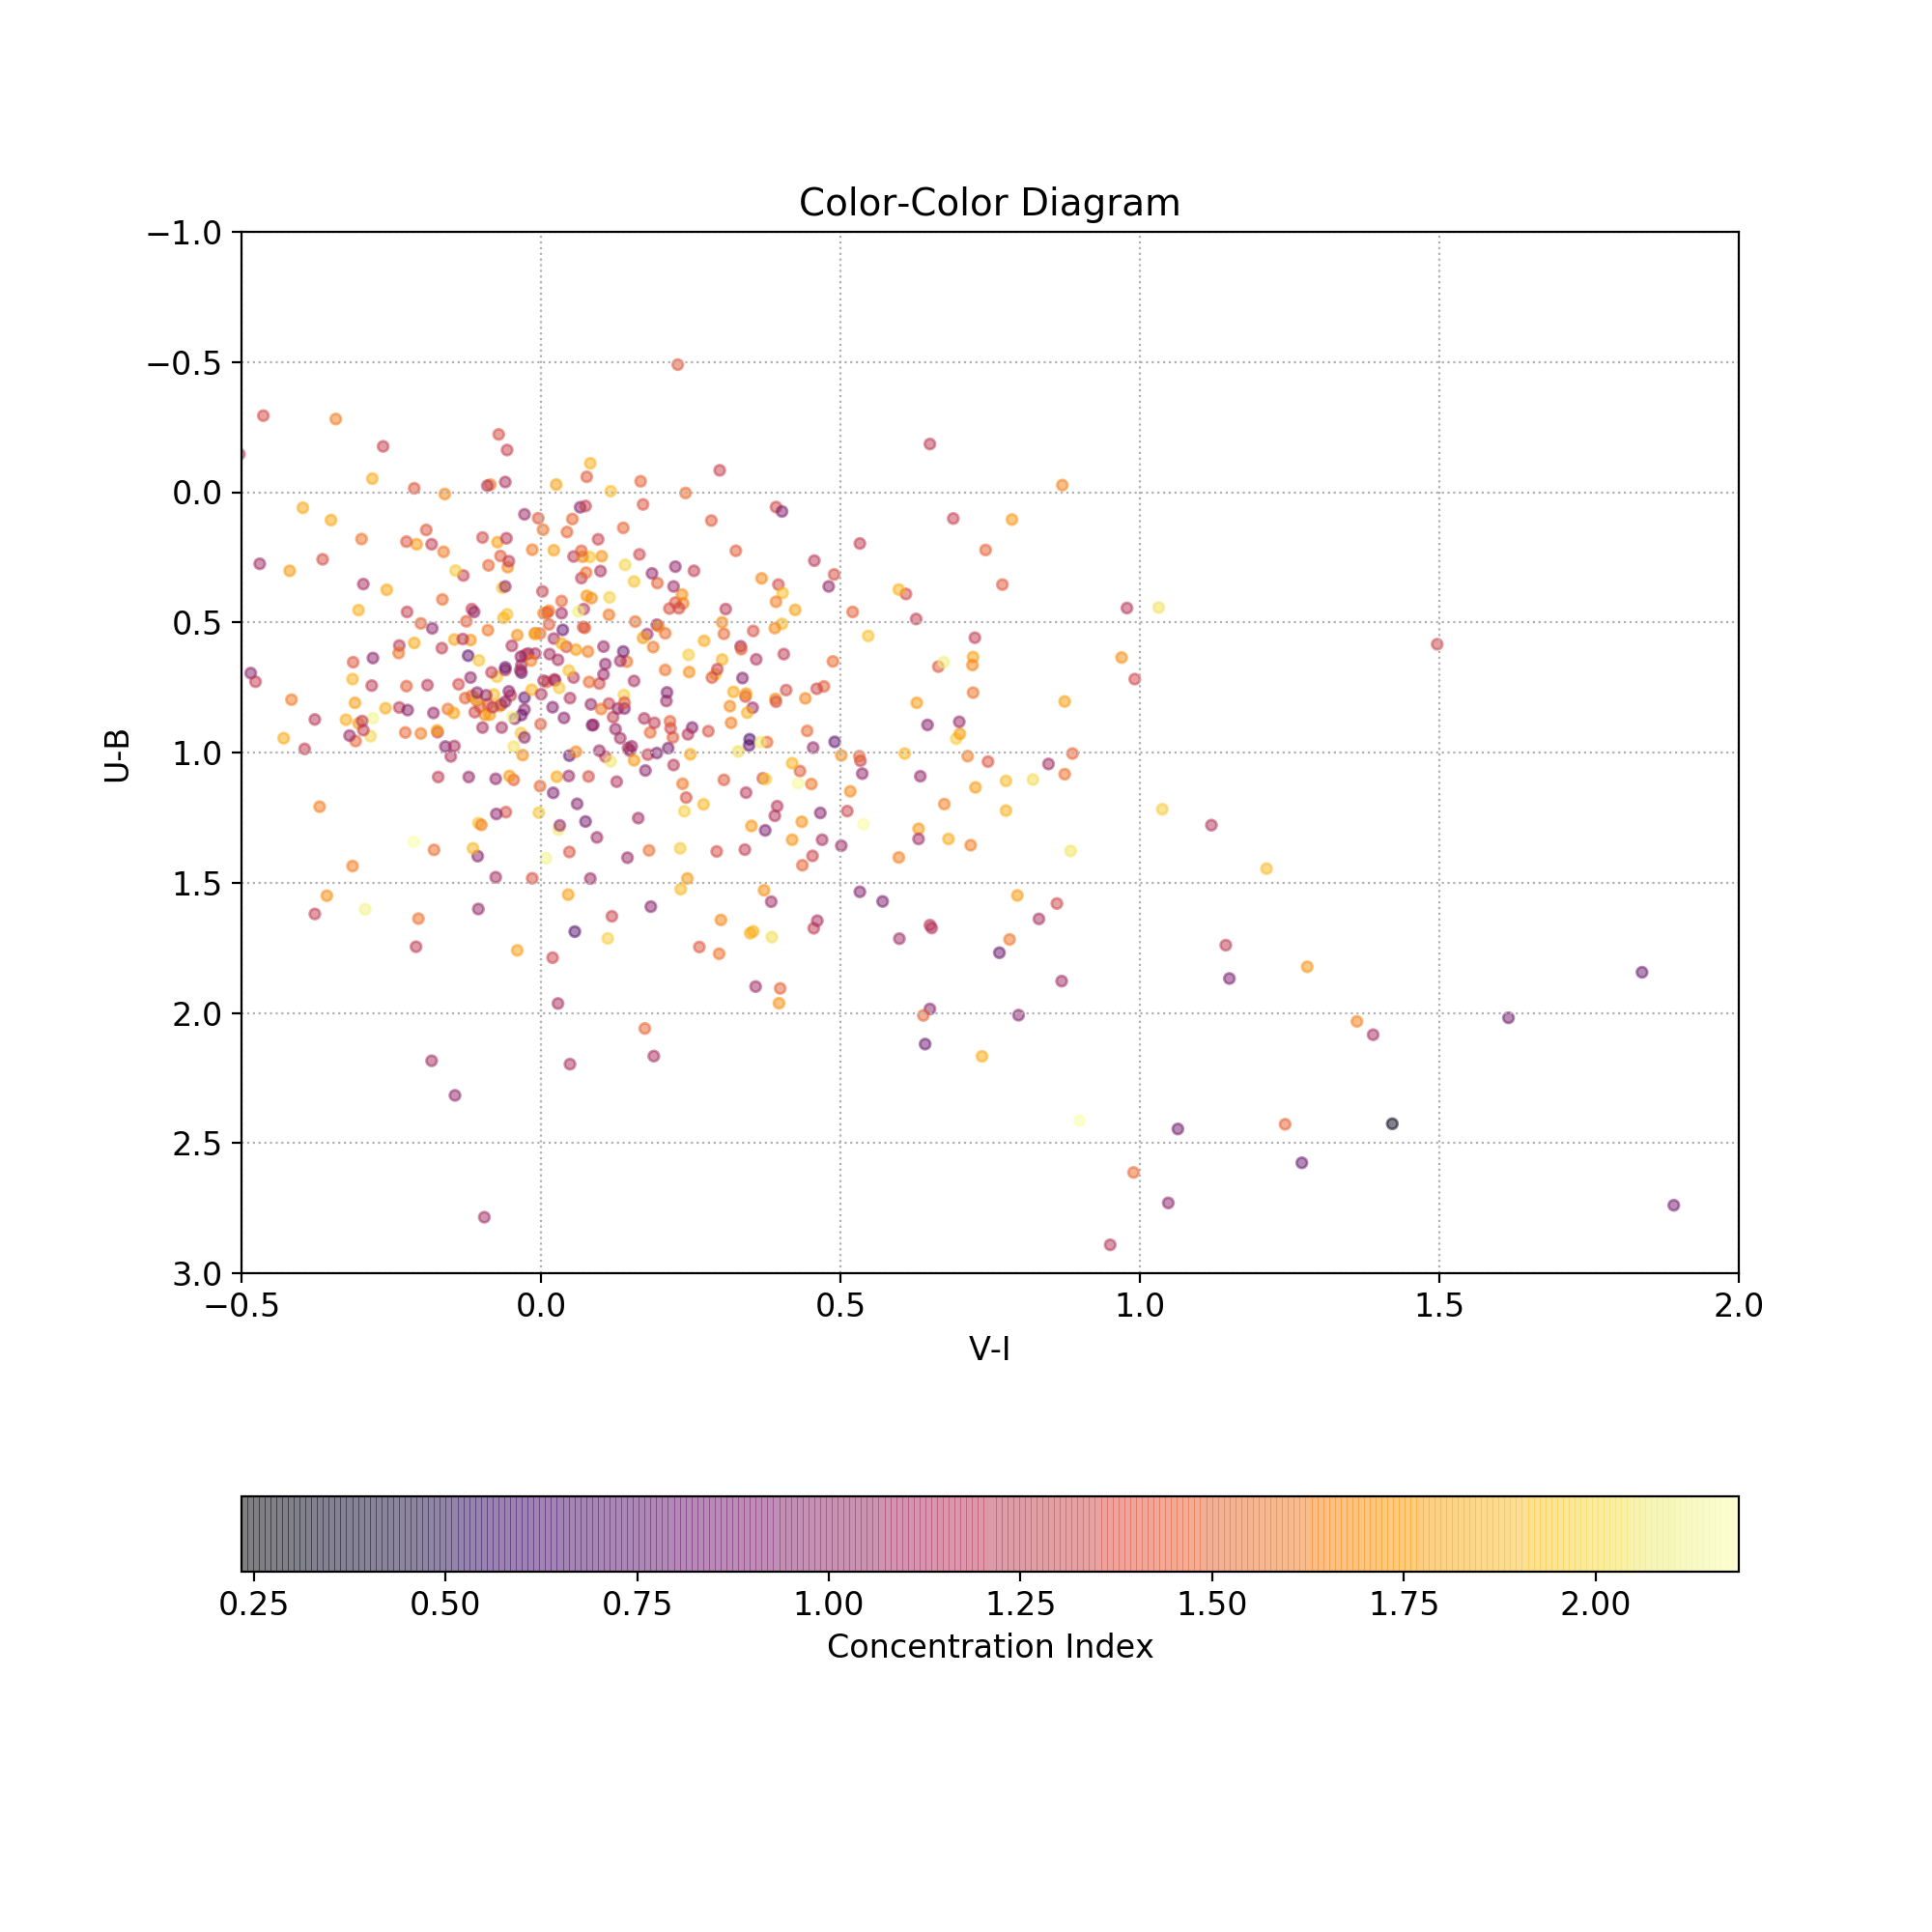

In [364]:
fig = plt.figure(figsize=[10,10])
plt.scatter(tbl[V]-tbl[I], tbl[U]-tbl[B], alpha=.5,s=15,c=tbl['CI'],cmap='inferno')
cb = plt.colorbar(orientation='horizontal')
# plt.scatter(tbl[V]-tbl[I], tbl[U]-tbl[V], alpha=.5,s=8,c='r')

plt.ylim(3,-1)
plt.xlim(-.5,2)

plt.xlabel('V-I')
plt.ylabel('U-B')
plt.title('Color-Color Diagram')

plt.grid(ls=':')
cb.set_label('Concentration Index')

Let's also take a look at the concentration index itself

<IPython.core.display.Javascript object>


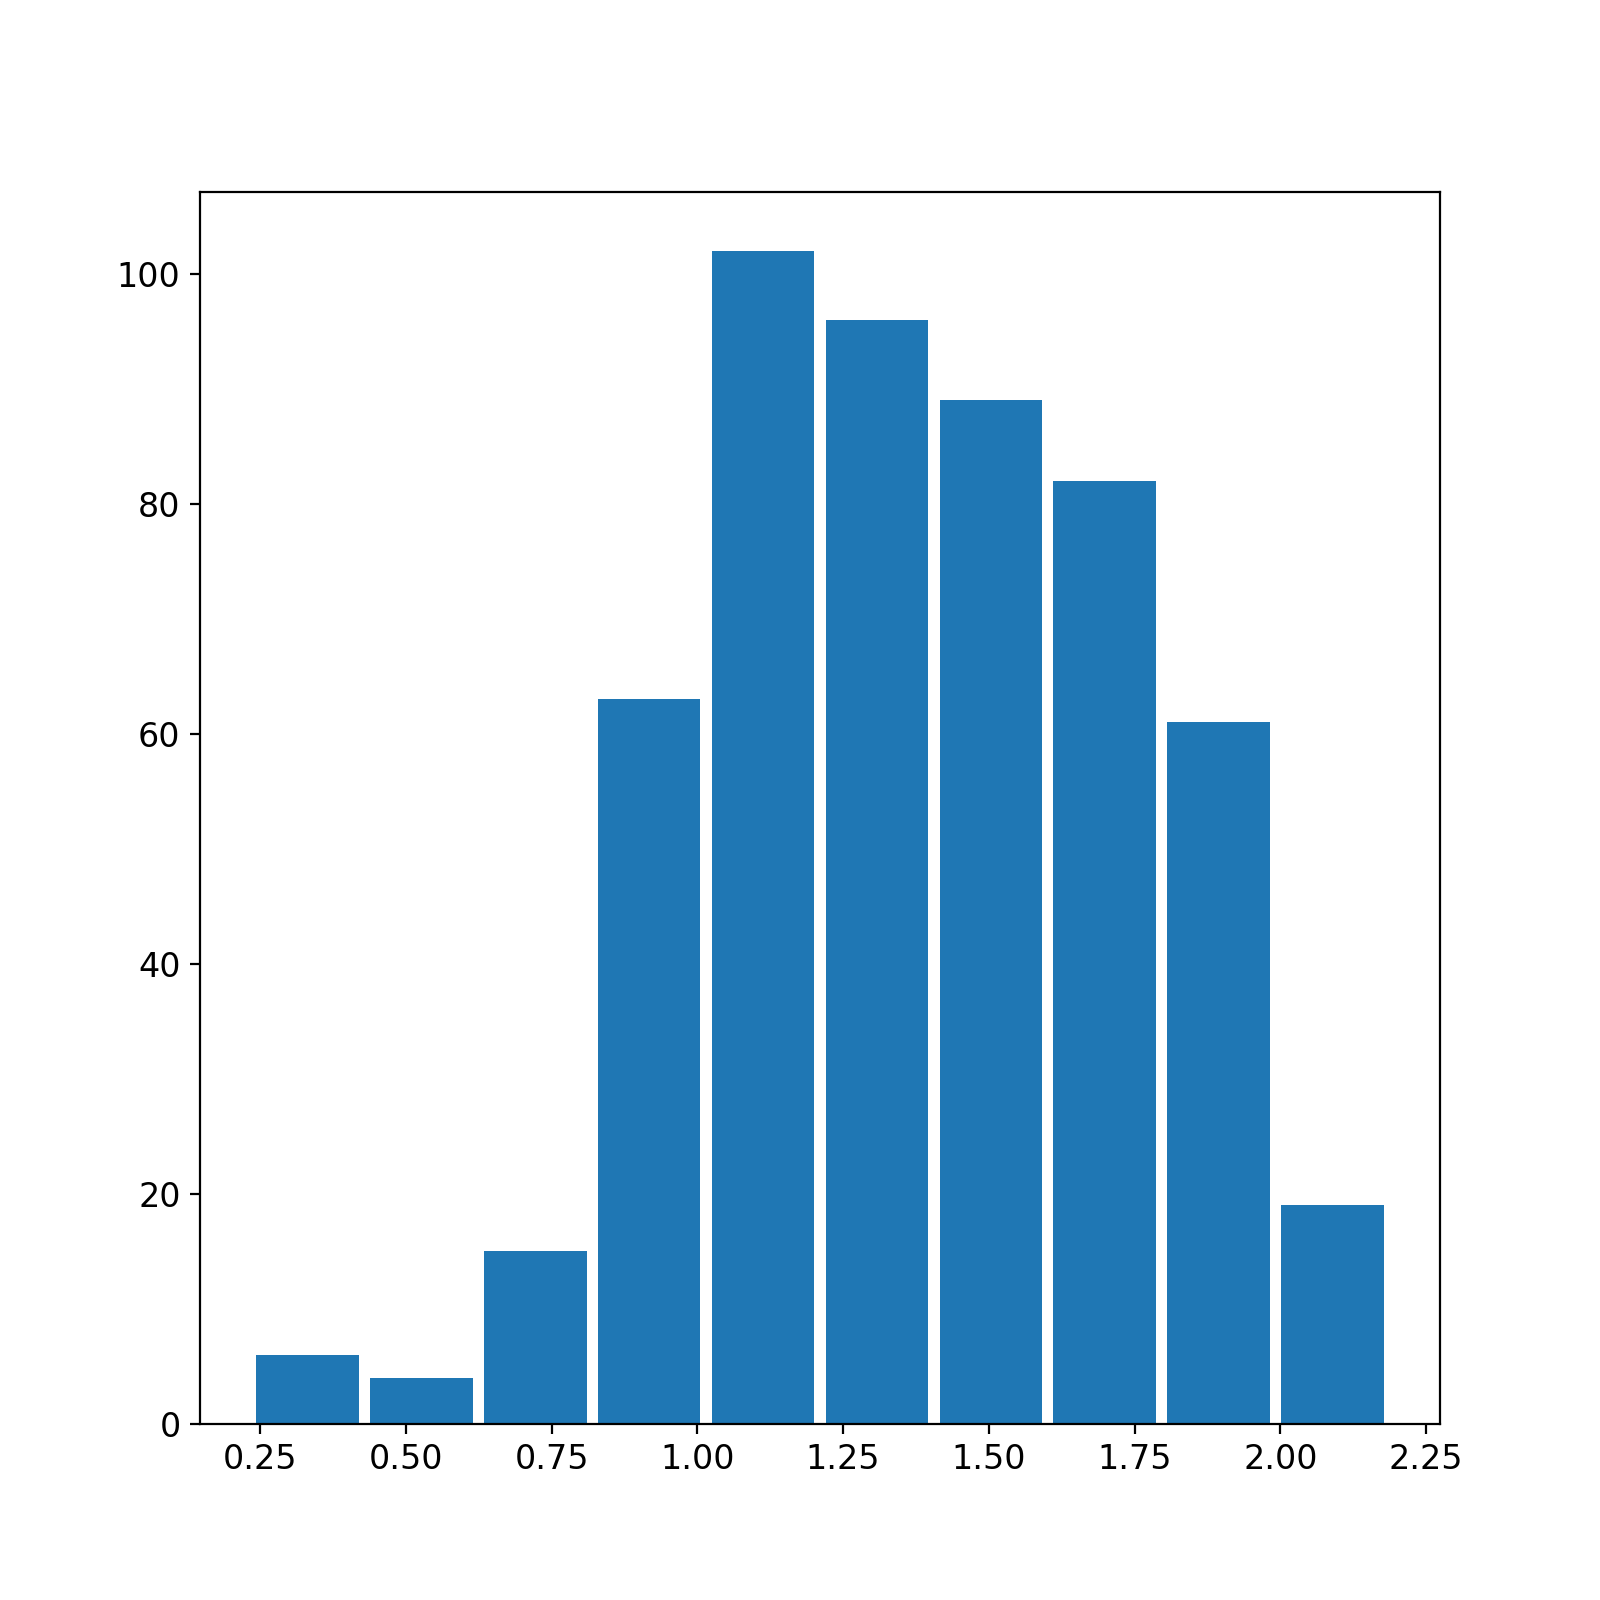

In [368]:
fig = plt.figure(figsize=[8,8])
hist, bins, patches = plt.hist(tbl['CI'],rwidth=.9)

Plot the detections over the reference image, color them by CI

<IPython.core.display.Javascript object>


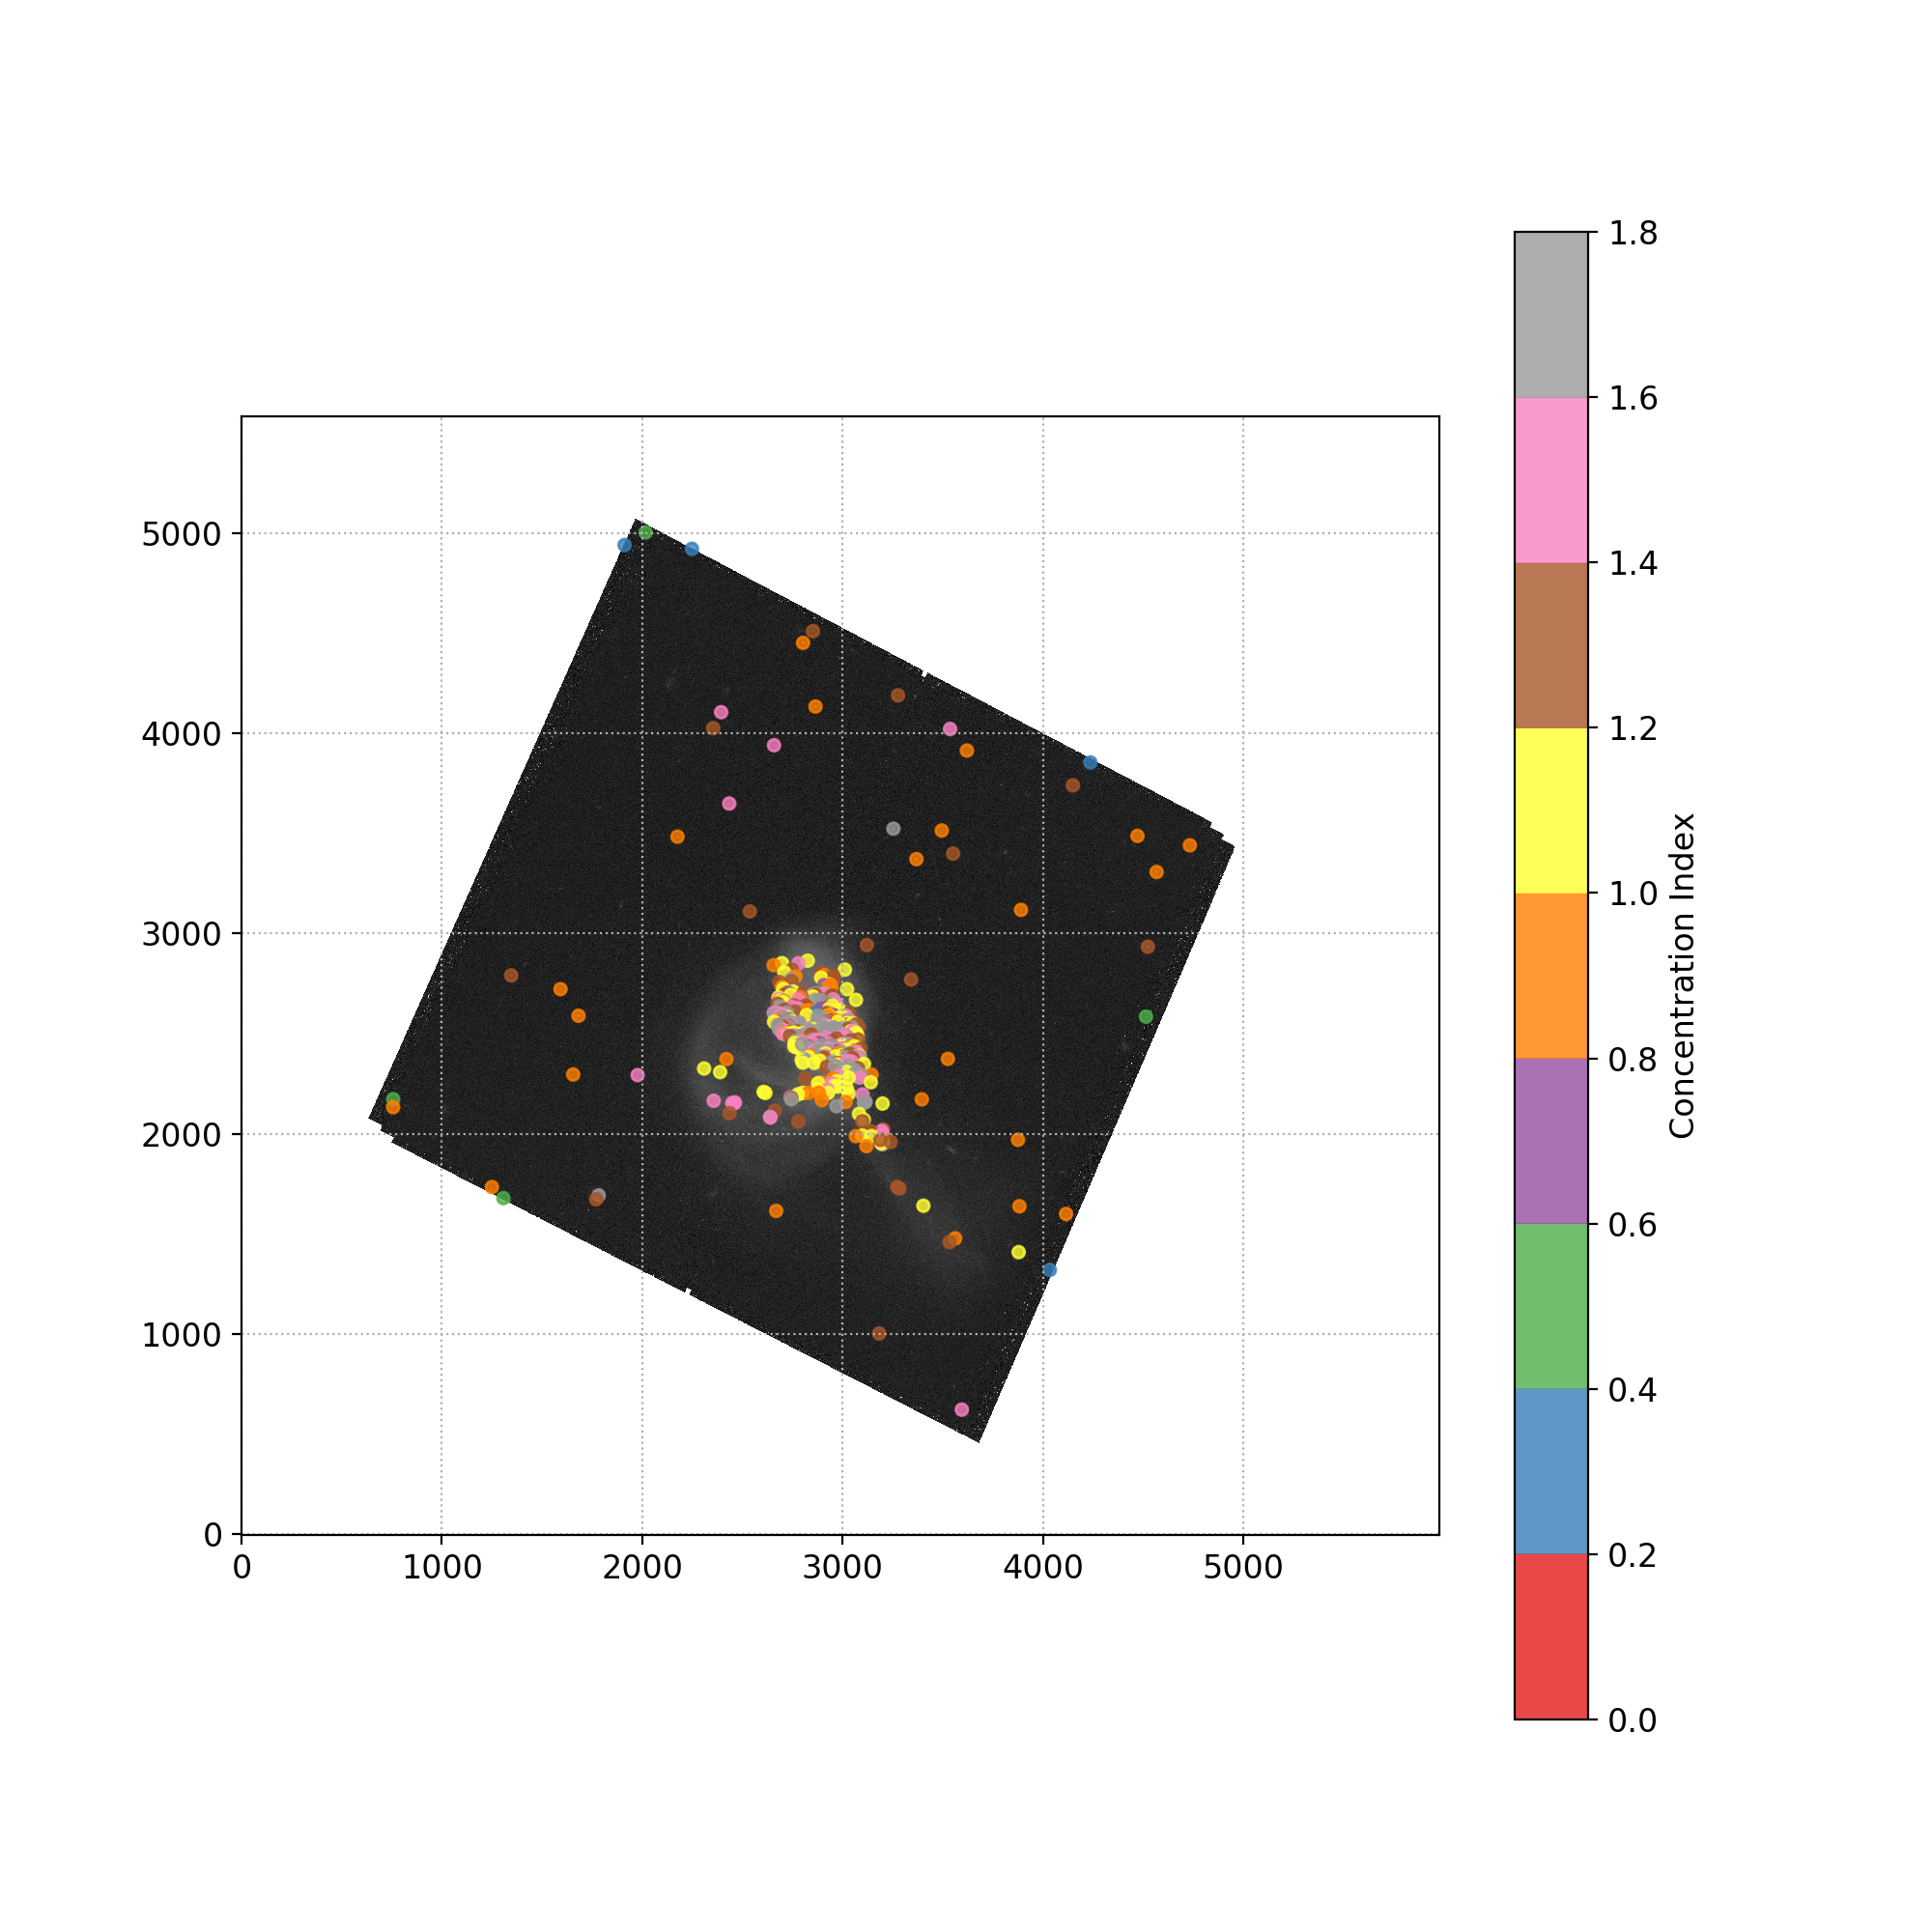

In [369]:
good = ~np.isnan(tbl['CI'])

data = fits.getdata('../data/NGC1614/F555W_NGC1614_WFC3_UVIS_drc.fits')
z1, z2 = zscale.zscale(data)


fig = plt.figure(figsize=[10,10])
plt.imshow(data, origin='lower', vmin=z1, vmax=150.*z2, norm=LogNorm(),cmap='Greys_r')


ci_good = tbl['CI'][good]
x = tbl['X'][good]
y = tbl['Y'][good]
plt.scatter(x-1, y-1, alpha=.8,s=20, vmin=0., vmax=1.8, c=ci_good, cmap='Set1')
plt.grid(ls=':')
cb = plt.colorbar()
cb.set_label('Concentration Index')


### Use the model data:

Here we have written a small class that helps manage all the synthetic photometry model data.  Basically, this takes the output model file and organizes it, and has methods (functions) that make accessing the relevant bits of the model easy.

In [370]:
class model_catalog():
    def __init__(self, model_file, delimiter='\t'):
        self.model_df = pd.read_csv(model_file, sep=delimiter) # The non reshaped input data
        
        self.ages = np.unique(self.model_df['Age ']) # Array of unique ages
        self.n_age = self.ages.shape[0] # number of unique ages
        
        self.exts = np.unique(self.model_df['E(B-V)']) # Array of unique E(B-V) values
        self.n_ext = self.exts.shape[0] # Number of unique E(B-V) values
        
        self.n_filts = self.model_df.shape[-1] - 3 # Number of filters.  The minus 3 is because the first 3 cols are other data
        self.filts = self.model_df.columns[-42:].tolist() # The list of filters
        
        self.model_mags = self.model_df.as_matrix()[:,-1*n_filts:].reshape((n_age,n_ext,n_filts)) # reshape into 3D array
        # First axis is the age axis (length = n_age). Second is E(B-V), third is filter axis
        
    def get_evolution(self, ext_val, *filters):
        # This method returns the magnitudes for the sequence of all the ages, for a given
        # extinction value (ext_val), for an input list of filters (filters).
        # The returned value is a numpy array with one row for each filter input, and a column
        # for each of the age values contained in self.ages
        
        # NOTE: the names of the desired filters MUST be as they appear as the columns the model file.
        # When creating the model_catalog object, the .filts attribute prints the filters with their appropriate names
        # For example:
        # models = model_catalog('some_models_file.dat')
        # print models.filts
        ext_index = self.get_extinction_index(ext_val)
        
        filt_inds = []
        for filt in filters:
            filt_index = self.filts.index(filt)
            filt_inds.append(filt_index)
            
        evo_array = self.model_mags[:, ext_index, filt_inds].T # Transpose to make a row for each filter, makes unpacking easy
        return evo_array
    
    def get_extinction_index(self, ext_val):
        # Gets the index along the extinction axis corresponding to some extinction value <ext_val>
        min_ext = self.exts.min()
        max_ext = self.exts.max()
        if ext_val < min_ext or ext_val > max_ext:
            raise ValueError('{} is not within the bounds [{}, {}] of the computed E(B-V) values'.format(ext_val,min_ext,max_ext))
        ext_index = np.nonzero(self.exts==ext_val)[0][0]
        return ext_index

Create an instance of the model catalog class (read in a model file)

In [372]:
models = model_catalog('../sed_fitting/modconv_fcov0.5_allages_ngc1614_diff.dat')

<IPython.core.display.Javascript object>


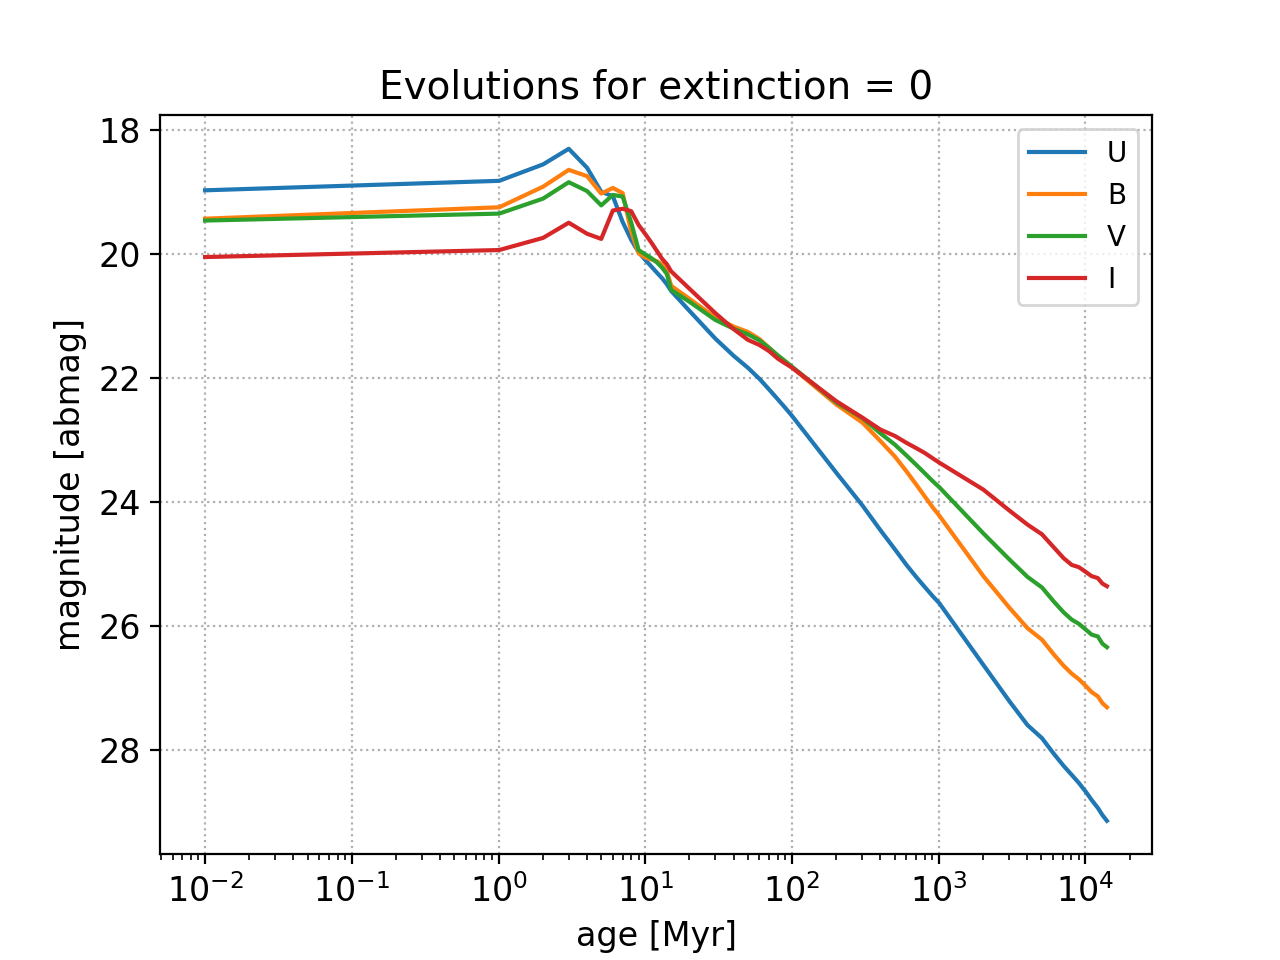

<IPython.core.display.Javascript object>


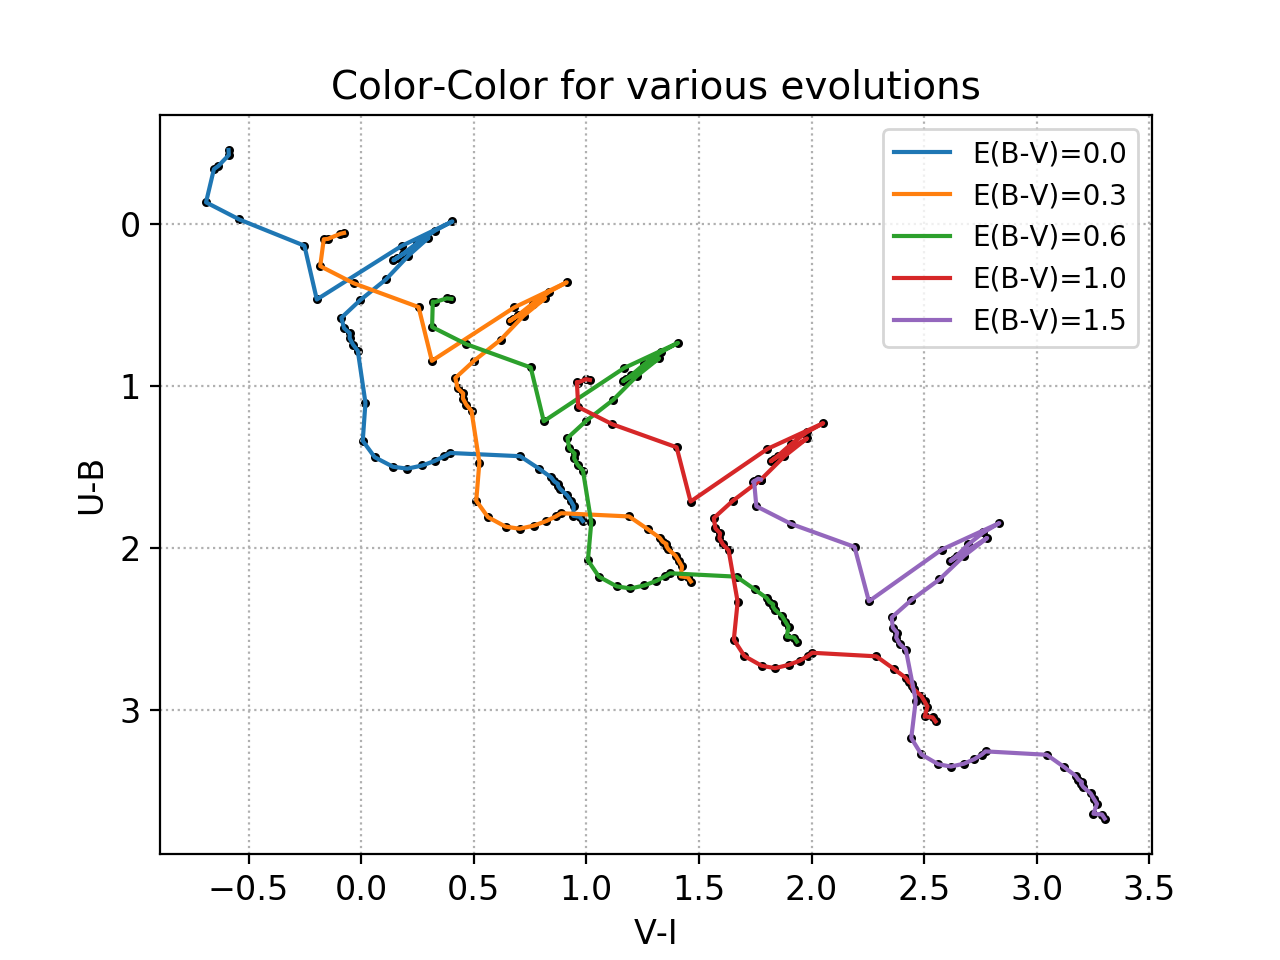

<IPython.core.display.Javascript object>


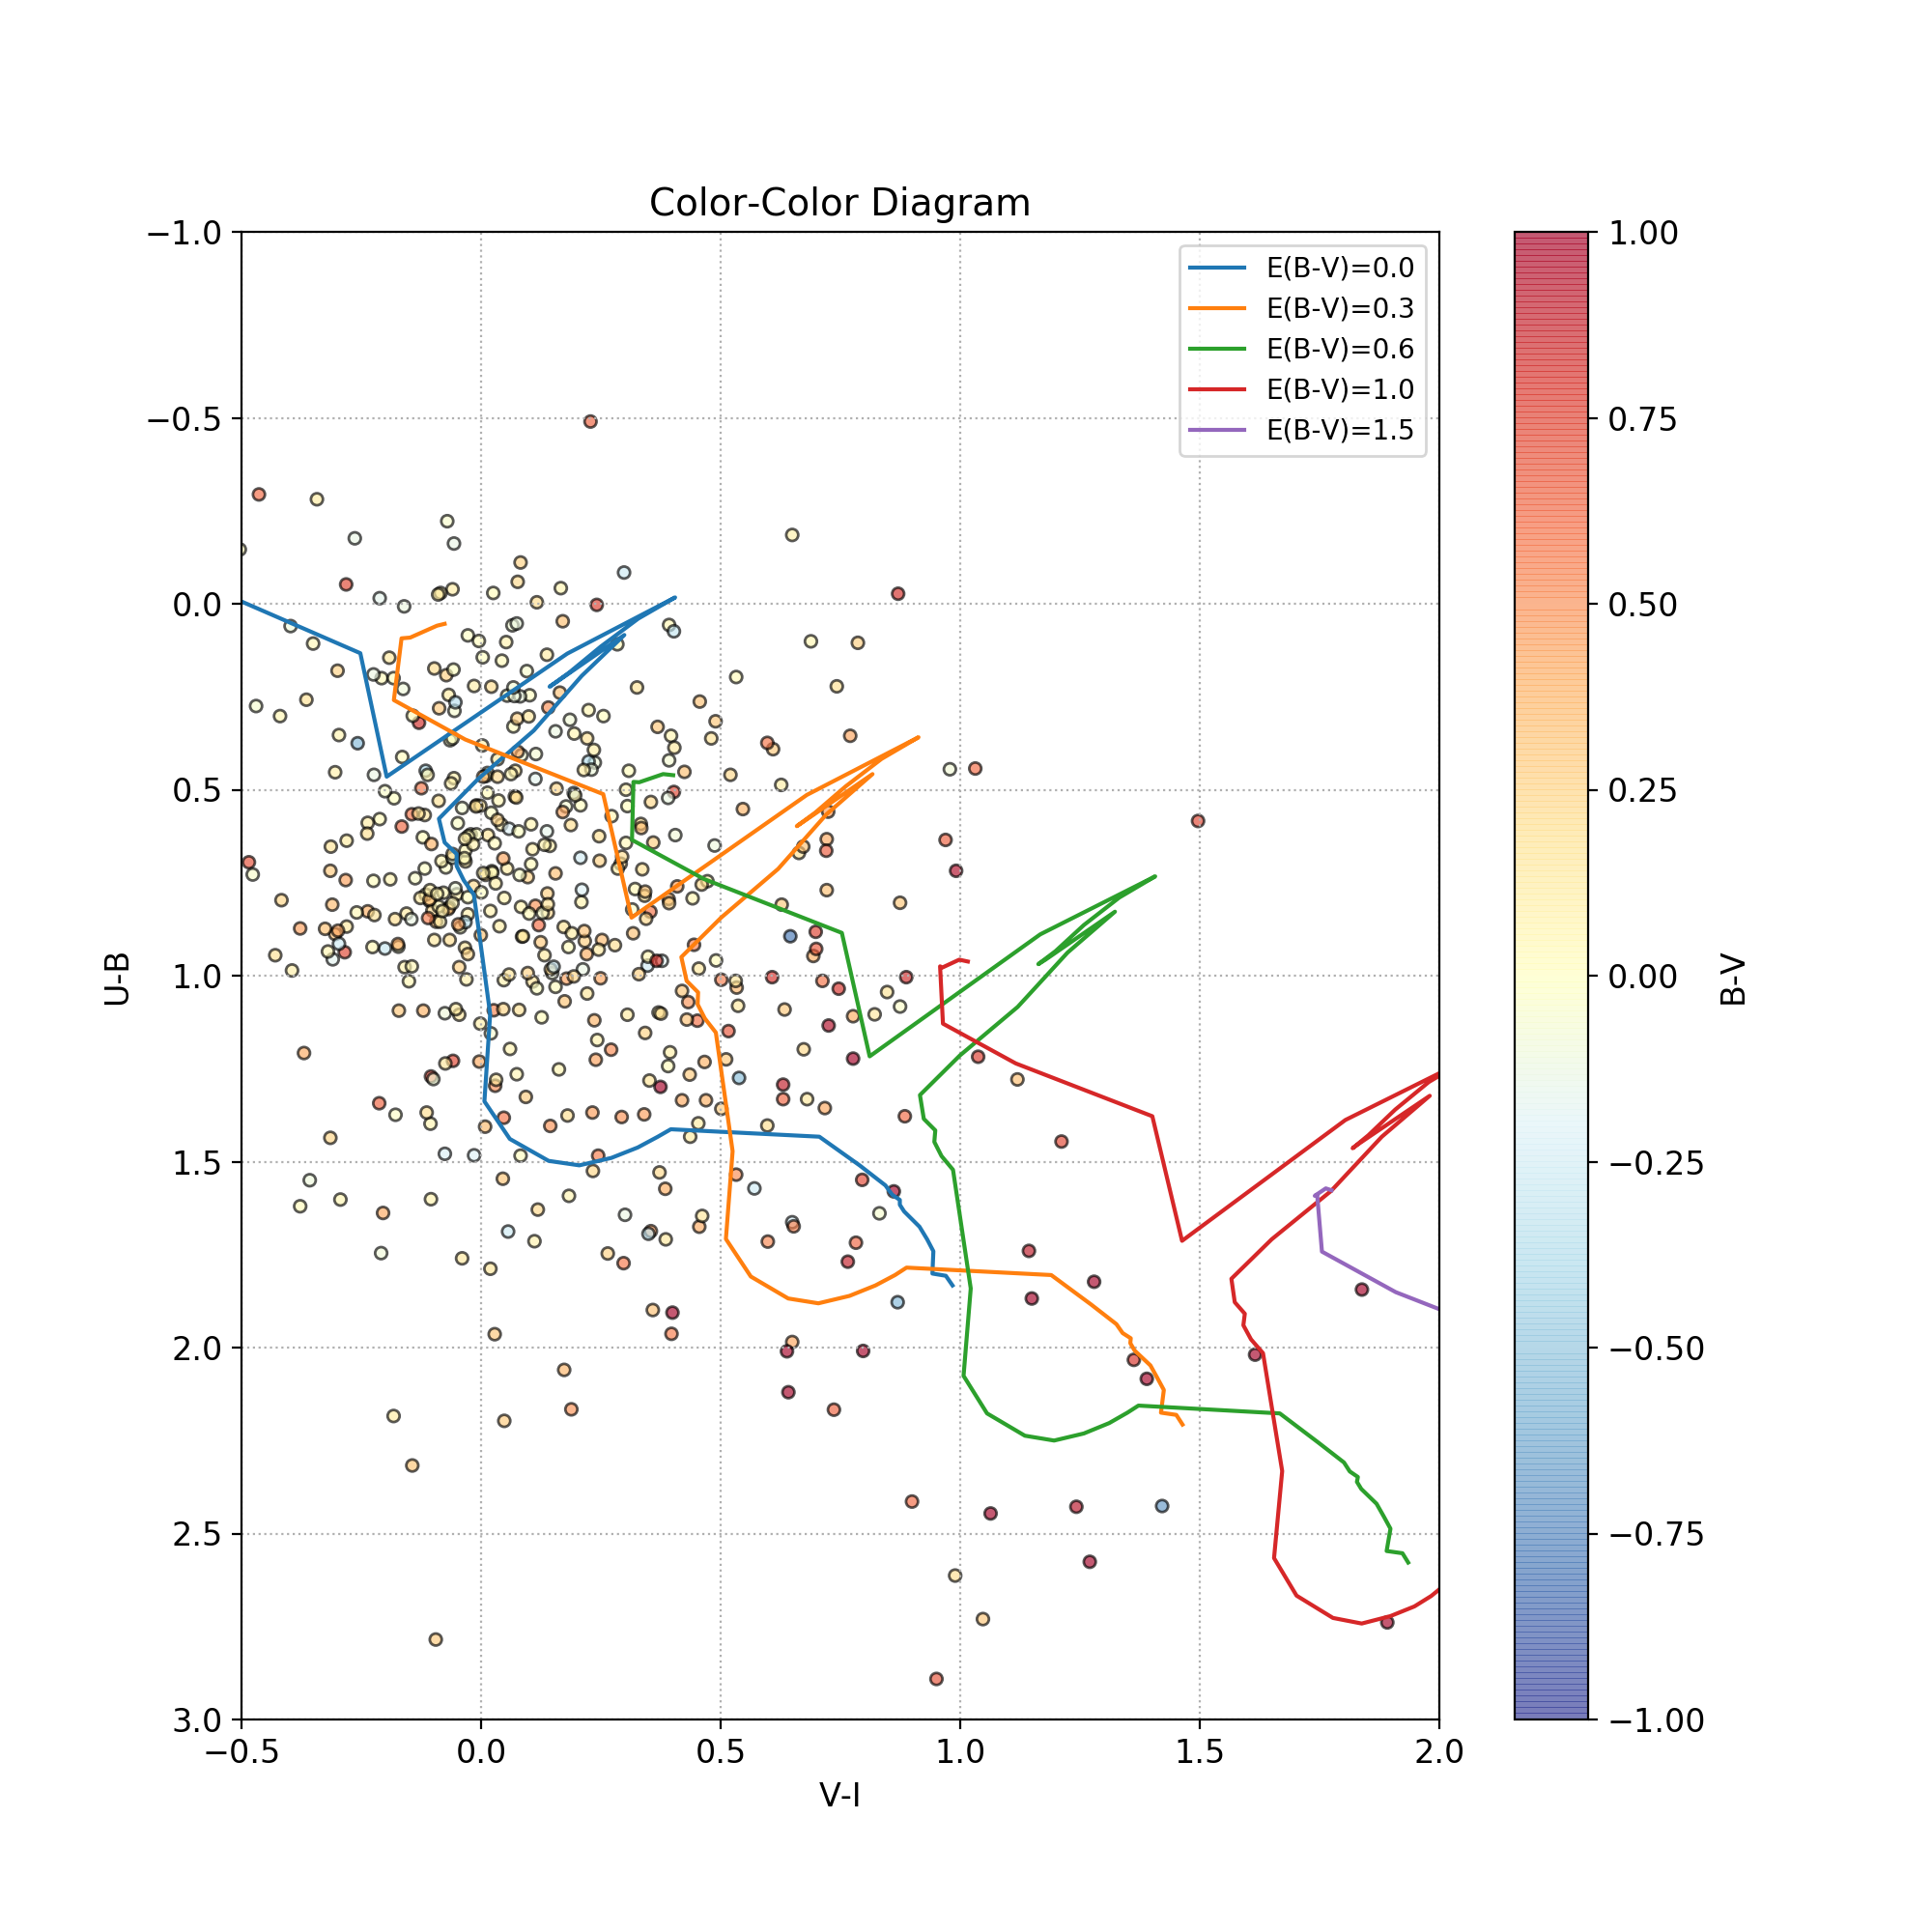

In [376]:

#-----------------------------------------------------------------------------------
# Plot the evolution curves of the models for extinction = 0
mu, mb, mv, mi = models.get_evolution(0.0, 'wu336w', 'wu438w', 'wu555w', 'wu814w')
plt.figure()
plt.plot(models.ages, mu, label = 'U')
plt.plot(models.ages, mb, label = 'B')
plt.plot(models.ages, mv, label = 'V')
plt.plot(models.ages, mi, label = 'I')
plt.legend(loc='best')
plt.xscale('log')
plt.xlabel('age [Myr]')
plt.ylabel('magnitude [abmag]')
plt.ylim(plt.ylim()[::-1])
plt.grid(ls=':')
plt.title('Evolutions for extinction = 0')

#-----------------------------------------------------------------------------------
# Plot the color-color evolutions for different extinctions
plt.figure()
exts = [0., 0.3, 0.6, 1.0, 1.5]
for ext in exts:
    e_mu, e_mb, e_mv, e_mi = models.get_evolution(ext, 'wu336w', 'wu438w', 'wu555w', 'wu814w')
    plt.plot(e_mv-e_mi, e_mu-e_mb, label='E(B-V)={}'.format(round(ext,2)))
    plt.scatter(e_mv-e_mi, e_mu-e_mb, c='k', s=5)
plt.ylim(plt.ylim()[::-1])
plt.xlabel('V-I')
plt.ylabel('U-B')
plt.grid(ls=':')
plt.legend(loc='best')
plt.title('Color-Color for various evolutions')

#-----------------------------------------------------------------------------------
# Plot the evolutions on top of the colors of the sources
fig = plt.figure(figsize=[10,10])
plt.scatter(tbl[V]-tbl[I], tbl[U]-tbl[B], c=tbl[B]-tbl[V], alpha=.65,s=20, cmap='RdYlBu_r', vmin=-1., vmax=1.,edgecolor='k')
plt.ylim(3,-1)
plt.xlim(-.5,2)
plt.grid(ls=':')
cb = plt.colorbar()
plt.xlabel('V-I')
plt.ylabel('U-B')
cb.set_label('B-V')

for ext in exts:
    e_mu, e_mb, e_mv, e_mi = models.get_evolution(ext, 'wu336w', 'wu438w', 'wu555w', 'wu814w')
    plt.plot(e_mv-e_mi, e_mu-e_mb, label='E(B-V)={}'.format(round(ext,2)))
plt.legend(loc='best')
plt.title('Color-Color Diagram')

<IPython.core.display.Javascript object>


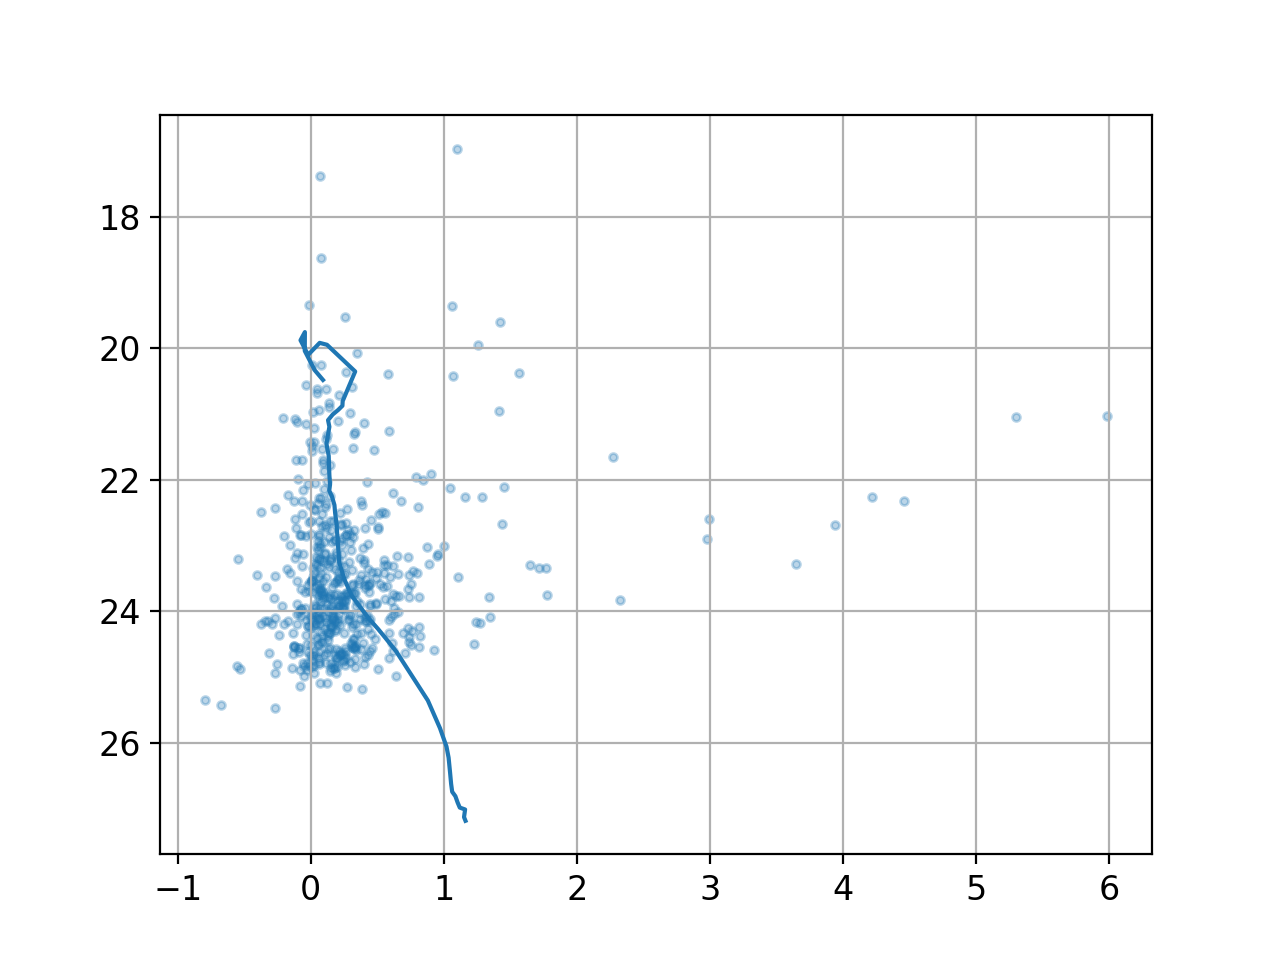

In [346]:
mu, mb, mv, mi = models.get_evolution(0.2, 'wu336w', 'wu438w', 'wu555w', 'wu814w')
fig = plt.figure()
plt.scatter(tbl[B]-tbl[V], tbl[V], alpha=.3, s=8)
plt.plot(mb-mv, mv)
plt.ylim(plt.ylim()[::-1])
plt.grid()